# Lab 3: Satellite Imagery to detect disaster locations 

Now that you have explored the data and applied the CNN Models to predict whether a satellite image contains damage or not, you can use a visualization tool called, "GradCAM" to analyze which parts of a satellite image contribute to the binary predictions of your CNN Models, either damaged or undamaged. In addition, you will also explore geo-locations of identified damaged areas in an interactive map. 

In this lab, you will apply the following steps:

1. Import Python packages
2. Load the dataset
3. Load the pre-trained model
4. Evaluate Model
5. Analyze classification features using GradCAM
6. Explore geo-locations of identified damaged areas

##  1. Import Python packages

Run the next cell to import that Python packages you'll need for this lab.

Note the `import utils` line. This line imports the functions that were specifically written for this lab. If you want to look at what these functions are, go to `File -> Open...` and open the `utils.py` file to have a look.

In [1]:
import os, logging

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

import utils

# Ignore tf warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

print('All packages imported successfully!')

All packages imported successfully!


## 2. Load the dataset

In [2]:
test_dataset_dir = './data/test/'

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    test_dataset_dir, 
    target_size = (150, 150),
    batch_size = 32,
    shuffle = False,                           
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.


You can define the correspondency between the model labels and the categories of the problem.

In [3]:
label2cat = {1: 'visible_damage',
             0: 'no_damage'}

## 3. Load the pre-trained model

Since the the model requires GPU and a lot of time to train, you will load the pre-trained model from the `models` folder. This is the same model that you have used in the design notebook.

* `cnn_100epochs_Adam.hdf5`: Pre-trained CNN model using 100 epochs with data augmentation.

In [4]:
model = load_model('models/cnn_100epochs_Adam.hdf5', compile=False)
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])

print('Model loaded!')

Model loaded!


## 4. Evaluate Model

Check the performance of the pre-trained model on the test set with the additional augmented images. The augmented dataset can create more variety in the dataset and simulate potential biases such as different camera angles, lightning conditions, etc.

63/63 [==============================] - 24s 370ms/step


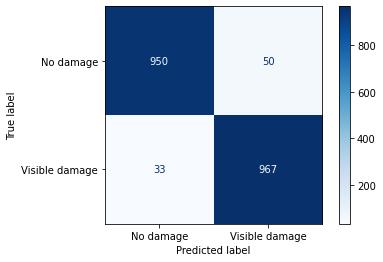

In [5]:
# Plot confusion matrix
y_labels = test_generator.classes
y_predictions = model.predict(test_generator)

utils.display_confusion_matrix(y_labels, y_predictions) 

Just to remind that the model performance is very similar in both cases

In [6]:
accuracy, precision, recall = utils.get_performance_metrics(y_labels, y_predictions.reshape(-1))

print(f'Accuracy:  {accuracy}')
print(f'Precision: {precision}')
print(f'Recall:    {recall}')

Accuracy:  0.9585
Precision: 0.9508357915437562
Recall:    0.967


## 5. Analyze classification features using GradCAM

[GradCAM](https://arxiv.org/abs/1610.02391) is a visualization tool that can be applied to convolutional neural networks (CNNs) to highlight the important regions in an input image that contribute to the prediction made by the network. Since CNN models are often large and complex models, it is difficult to understand how the network is making its predictions. GradCAM creates a heatmap on the image where each pixel represents a weighted sum of the predicted class score.

<img src='images/gradcam1.jpg'>


### 5.1 Analyzing pairs of images with GradCAM

To better illustrate the performance of the CNN, first analyze pairs of `damage` and `no_damage` images at the same location. Consider what features are highlighted in pink or blue by GradCAM. Did GradCAM make the correct interpretation or did it misinterpret features like shadows or blurriness in the image as evidence of damage? 

**Note:** The areas of "high importance" (pink) in the GradCAM images aren't attempting to show where there is evidence of damage or no damage, rather, these are just the areas of the images that carried the most weight in the determination of the model output. So, it's important to have a look and see what parts of the image are most important in making this determination and identify whether it looks like the model is focusing on the wrong things, or correctly identifying the important features in an image. 

In [7]:
# Find "damage" and "no_damage" image pairs that have the same coordinates
matches = utils.find_matching_images(test_dataset_dir)
    
utils.interact_with_slider(
    utils.display_predictions_gradcam,
    0, len(matches)-1,
    model, label2cat, matches, test_dataset_dir
)

There are 82 images in the set


interactive(children=(IntSlider(value=0, description='Image index', max=81), Output()), _dom_classes=('widget-…

## 6. Explore geo-locations of identified damaged areas

When you run the cell below, you'll be plotting up a map of the locations included in your dataset and your assessment of visible damage or no damage. At this point, it's also worth thinking about another sort of "total damage" assessment that you could provide with a tool like this. With an analysis of the total area or total number of structures or an estimate of the total number of people affected, you could start to put together an estimate of the total damage incurred with this storm. However, each of these estimates would come with different potential uncertainties and depending on the goals of your assessment you would need to weigh the tradeoffs between them. 

In [8]:
# This will take about two minutes to run
utils.show_predictions_on_map(
    y_predictions,
    test_generator.filenames,
    {'green':(0.0, 0.4), 'orange':(0.4, 0.6), 'red':(0.6, 1)}
)

Red = "Damage"

Orange = "Low confidence (0.4 to 0.6) in either damage or not"

Green = "No damage"